In [1]:
from itertools import permutations as perms
from itertools import product
import numpy as np
import MultiPoint as mp
import propagator 
import wignerD as wd

In [2]:
%matplotlib inline
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()
import numpy as np

In [3]:
class phi_tilde:    
    def __init__(self,k,alpha=0,l=0,m=0):
        self.k=k
        self.alpha=alpha
        self.l=l
        self.m=m

In [4]:
def plotlog(x, y, alpha, xrange=1, numx=2):
    xv = np.logspace(np.log10(x), np.log10(x) + xrange, numx)
    C = y / (x**alpha)
    yv = C * xv**(alpha)
    plt.loglog(xv, yv)

### Some simple functions

In [5]:
def norm(K):
    return np.linalg.norm(K)

In [6]:
def legendrep(Q1, Q2, nlam):
    EQ1 = Q1/norm(Q1)
    EQ2 = Q2/norm(Q2)
    RHO = -sum(EQ1*EQ2)
    
    val = [1, RHO]
    for L  in range(1, nlam-1):
        newval = ( (2*L+1)*RHO*val[L]-L*val[L-1] ) / (L+1)
        val.append(newval)
        
    return val

In [7]:
print(legendrep([1, 0, 0], [1, 0, 0], 10))
print(legendrep([1, 0, 0], [-1, 0, 0], 10))

[1, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0]
[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 1. Two point correlations

In [8]:
def I2N(N, FA, p1, sequence):
    lam0=0
    lam=0
    
    if sequence == (0,0): # AA
        value = mp.IAAresum(N,FA,lam0,lam,p1)
    elif sequence ==(0,1): # AB
        value = mp.IABresum(N,FA,lam0,lam,p1)
    elif sequence == (1,1): # BB
        value = mp.IAAresum(N,1-FA,lam0,lam,p1)
    else:
        value=0.0
    return value

In [9]:
def twoPointCorr(pset,N,FA,phi1,phi2):
    val = 0.0+0.0j
    for ordered in perms([phi1,phi2]):
        q1=-ordered[0].k

        # chemical sequence, A is 1
        sequence = (ordered[0].alpha,ordered[1].alpha)

        # Calculate or look up eigenstuff
        p = pset.get_vec_prop(q1)
        val += I2N(N, FA, p.prop(0), sequence)
    return val

In [10]:
def s2wlc_zeroq(pset, N, FA):
    s2 = np.zeros((2,2),dtype='complex')

    FB = 1.0-FA
    s2[0][0] = FA*FA
    s2[1][1] = FB*FB
    s2[0][1] = FA*FB
    s2[1][0] = FB*FA
    
    return s2

In [11]:
def s2wlc(pset, N, FA, K, sequence='all'):
    s2 = np.zeros((2,2),dtype=type(1+1j))
    k1=np.array([0,0,1])*K
    k2=-k1

    if sequence == 'all':
        if norm(k1) < 1e-5:
            s2 = s2wlc_zeroq(pset, N, FA)
            return s2
            
        for a1 in [0,1]:
            for a2 in [0,1]:
                phi1 = phi_tilde(k1,alpha=a1)
                phi2 = phi_tilde(k2,alpha=a2)
                s2[a1][a2] = twoPointCorr(pset, N, FA, phi1, phi2)
    else:
        a1, a2 = sequence
        if norm(k1) < 1e-5:
            s2 = s2wlc_zeroq(pset, N, FA)
            return s2[a1][a2]
        
        phi1 = phi_tilde(k1,alpha=a1)
        phi2 = phi_tilde(k2,alpha=a2)
        s2 = twoPointCorr(pset, N, FA, phi1, phi2)
        
    return s2

In [12]:
def s2inverse_zeroq(pset, N, FA):
    s2 = np.ones((2,2),dtype='complex')
    
    return s2/(N**2)

In [13]:
def s2inverse(pset, N, FA, K):
    if norm(K) < 1e-5:
        s2inv = s2inverse_zeroq(pset, N, FA)
        return s2inv

    s2 = s2wlc(pset, N, FA, K)
    s2inv = np.zeros((2,2),dtype=type(1+1j))
    
    [s2aa, s2ab], [s2ba, s2bb] = s2
    det = s2aa*s2bb - s2ab*s2ba
    
    s2inv[0,0] = s2bb/det
    s2inv[0,1] = -s2ab/det
    s2inv[1,0] = -s2ba/det
    s2inv[1,1] = s2aa/det
    
    return s2inv

In [ ]:
N = 100
K = 0.0
FA = 1.0

nlam=1
pset=propagator.prop_set(nlam=nlam)

s2wlc(pset, N, FA, K, sequence=[0, 0])

In [ ]:
N = 100
K = 0.0
FA = 0.1

nlam=1
pset=propagator.prop_set(nlam=nlam)

s2inverse(pset, N, FA, K)

In [ ]:
N=10
FA=0.5

nlam=4
pset=propagator.prop_set(nlam=nlam)


sequence = [0,0]
KV = np.logspace(-4,3,10)
s2 = np.zeros((len(KV)),dtype=type(1+1j))
for ind, K in enumerate(KV):
    s2[ind] = s2wlc(pset, N, FA, K, sequence=sequence)/(N**2)

In [ ]:
# plt.loglog(KV, np.real(np.sum(np.vstack([s2[0,0,:], s2[0,1,:], \
#                                          s2[1,0,:], s2[1,1,:]]), axis=0)))
plt.loglog(KV, np.real(s2))
plotlog(1e1,1e-1,-1)
plt.show()

## Three point correlations

In [ ]:
def I3N(N,FA,lam0_1,lam_1,mu1,\
            lam0_2,lam_2,mu2,\
            p1,p2,\
            sequence):
    
    value = 0
    if sequence == (0,0,0): # AAA
        value = mp.IAAAresum(N,FA,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    elif sequence == (0,0,1): # AAB
        value = mp.IABBresum(N,1-FA,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    elif sequence == (0,1,1): # ABB
        value = mp.IABBresum(N,FA,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    elif sequence == (1,1,1): # BBB
        fb=1.0-FA
        # Same as AAAA except fb instead of FA
        value = mp.IAAAresum(N,fb,lam0_1,lam_1,\
                                  lam0_2,lam_2,\
                                  p1.prop(mu1),\
                                  p2.prop(mu2))
    else:
        pass
    
    return value

### Space ordering of wavevectors

In [ ]:
# Inputs
#     pset (propagator.prop_set), the set of propagators used so FAr
#     N (float), number of Khun lengths
#     FA (float), fraction of type A
#     prop1 (phi_tilde), contains k and alpha
def threePointCorr(pset,N,FA,phi1,phi2,phi3):
#     print('Warning: Winger D hasnt been implemented!')
    nlam=pset.nlam
    # The first and last lam must be zero 
    mu1=0
    mu2=0
    lam0_1=0
    lam_2=0
    
    total = 0.0+0.0j
    # The Points can be visited in any order
    for ordered in perms([phi1,phi2,phi3]):
        # while phi1.k is the absolute Fourier position
        # q1 is the relitive Fourier position of 1 and 2
        q1=-ordered[0].k
        q2=-ordered[0].k-ordered[1].k
        
        # chemical sequence, A is 1
        sequence = (ordered[0].alpha,ordered[1].alpha,ordered[2].alpha)
        
        # Calculate or look up eigenstuff
        p1 = pset.get_vec_prop(q1)
        p2 = pset.get_vec_prop(q2)

        # Calculate Legendre polynomial
        PL = legendrep(q1, q2, nlam)
        
        # Angular sum
        for lam in range(0,nlam):
            lam_1, lam0_2 = lam, lam
            value = I3N(N,FA,lam0_1,lam_1,mu1,\
                        lam0_2,lam_2,mu2,\
                        p1,p2,\
                        sequence)

            # Wigner D goes here!
            value *= PL[lam]

            total = total + value
    return total

In [ ]:
def s3wlc_zeroq3(pset, N, FA, Ks):
    k1, k2, k3 = Ks
    s3 = np.zeros((2,2,2),dtype=type(1+1j))

    FB = 1.0-FA
    s2 = s2wlc(pset, N, FA, norm(k1))
    s3[0][0][0] = s2[0][0]*FA*N
    s3[0][0][1] = s2[0][0]*FB*N
    s3[0][1][0] = s2[0][1]*FA*N
    s3[0][1][1] = s2[0][1]*FB*N
    s3[1][0][0] = s2[1][0]*FA*N
    s3[1][0][1] = s2[1][0]*FB*N
    s3[1][1][0] = s2[1][1]*FA*N
    s3[1][1][1] = s2[1][1]*FB*N
    
    return s3

In [ ]:
def s3wlc(pset, N, FA, Ks, sequence='all'):
    k1, k2, k3 = Ks
    if norm(k1+k2+k3) >= 1e-10:
        raise ValueError('Qs must add up to zero')

    if sequence=='all':
        s3 = np.zeros((2,2,2),dtype=type(1+1j))
        if norm(k3) < 1e-5:
            return s3wlc_zeroq3(pset, N, FA, Ks)
        
        for a1, a2, a3 in product([0,1], repeat=3):
            phi1 = phi_tilde(k1,alpha=a1)
            phi2 = phi_tilde(k2,alpha=a2)
            phi3 = phi_tilde(k3,alpha=a3)

            s3[a1][a2][a3] = threePointCorr(pset, N, FA, \
                                            phi1, phi2, phi3)
    else:
        a1, a2, a3 = sequence
        if norm(k3) < 1e-5:
            s3 = s3wlc_zeroq3(pset, N, FA, Ks)
            return s3[a1][a2][a3]

        phi1 = phi_tilde(k1,alpha=a1)
        phi2 = phi_tilde(k2,alpha=a2)
        phi3 = phi_tilde(k3,alpha=a3)
        s3 = threePointCorr(pset, N, FA, phi1, phi2, phi3)
        
    return s3

In [ ]:
N = 1000
FA = 1.0
K = 1e0

def set3Ks(K):
#     k1=np.array([0,0,1])*K
#     k2=np.array([0,0,-1])*K
#     k3=-k1-k2
    
    k1 = np.array([1,0,0])*K
    k2 = np.array([-0.5,0.5*np.sqrt(3),0])*K
    k3 = -k1-k2

    Ks = [k1, k2, k3]
    return Ks

nlam = 6
pset=propagator.prop_set(nlam=nlam)

Ks = set3Ks(K)
s3 = s3wlc(pset, N, FA, Ks, sequence=[0, 0, 0])

print(Ks)
print(s3)

In [ ]:
N=1
FA=1.0

nlam = 20
pset=propagator.prop_set(nlam=nlam)

sequence = [0,0,0]
KV = np.logspace(-2,5,50)
s3 = np.zeros((len(KV)),dtype=type(1+1j))
for ind, K in enumerate(KV):
    k = set3Ks(K)
    s3[ind] = s3wlc(pset, N, FA, k, sequence=sequence)/(N**3)

col = 1
plt.loglog(KV, abs(s3), '--', color=[col, 0.0, 1-col])
plt.loglog(KV[s3>0], abs(s3[s3>0]), '-', color=[col, 0.0, 1-col])
plotlog(1e1, 5e-3, -2, xrange=2)
plt.title('lam = ' + str(nlam))
    
plt.show()

In [ ]:
# KV = np.logspace(-2,5,50)
# s3 = np.zeros((2,2,2,len(KV)),dtype=type(1+1j))
# for ind, K in enumerate(KV):
#     k = setKs(K)
#     s3[:,:,:,ind] = s3wlc(pset, N, FA, k)/(N**3)

## Four point correlations

\begin{align*}
\underset{\alpha_{1}\alpha_{2}\alpha_{3}\alpha_{4}}{I_{1,2,3}^{\left(4\right)}\left(N\right)}= & \int_{0}^{N}ds_{3}\int_{0}^{s_{4}}ds_{2}\int_{0}^{s_{3}}ds_{1}\int_{0}^{s_{1}}ds_{0}\delta_{\alpha\left(s_{1}\right),\alpha_{1}}\delta_{\alpha\left(s_{2}\right),\alpha_{2}}\delta_{\alpha\left(s_{3}\right),\alpha_{3}}\delta_{\alpha\left(s_{4}\right),\alpha_{4}}\\
 & \cdot\mathcal{G}_{\lambda0_{1}\lambda_{1}}^{\mu_{1}}\left(s_{4}-s_{3},K_{1}\right)\mathcal{G}_{\lambda0_{2}\lambda_{2}}^{\mu_{2}}\left(s_{3}-s_{2},K_{2}\right)\mathcal{G}_{\lambda0_{3}\lambda_{3}}^{\mu_{3}}\left(s_{2}-s_{1},K_{2}\right)
\end{align*}

In [7]:
def I4N(N,FA,lam0_1,lam_1,mu1,\
           lam0_2,lam_2,mu2,\
           lam0_3,lam_3,mu3,\
           p1,p2,p3,\
           sequence):
    
    value = 0
    if sequence == (0,0,0,0): # AAAA
        value = mp.IAAAAresum(N,FA,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    elif sequence == (0,0,0,1): # AAAB
        value = mp.IAAABresum(N,FA,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))   
    elif sequence == (0,0,1,1): # AABB
        value = mp.IAABBresum(N,FA,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    elif sequence == (0,1,1,1): # ABBB
        fb=1.0-FA
        # Same as AAAB except fb instead of FA
        value = mp.IAAABresum(N,fb,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    elif sequence == (1,1,1,1): # BBBB
        fb=1.0-FA
        # Same as AAAA except fb instead of FA
        value = mp.IAAAAresum(N,fb,lam0_1,lam_1,\
                                   lam0_2,lam_2,\
                                   lam0_3,lam_3,\
                                   p1.prop(mu1),\
                                   p2.prop(mu2),\
                                   p3.prop(mu3))
    else:
        pass
    
    return value

### Space ordering of wavevectors

fourPointCorr
calculates
$\int_0^N d^4 s\left\langle \tilde{\psi}_{1}\tilde{\psi}_{2}\tilde{\psi}_{3}\tilde{\psi}_{3}\right\rangle $
.
The $\psi$s are not orientation dependent. This will change when
I introduce Maier-Saupe interaction.
The average is over the unperturbed distribution of a single WLC that
is N segments long with $f_{A}$ being of A type.
Each $\tilde{\psi}$ has an associated chemical identity, $\alpha$, and Fourier location, $\vec{k}$.

In [14]:
# Inputs
#     pset (propagator.prop_set), the set of propagators used so FAr
#     N (float), number of Khun lengths
#     FA (float), fraction of type A
#     prop1 (phi_tilde), contains k and alpha
def fourPointCorr(pset,wigset,N,FA,phi1,phi2,phi3,phi4):
    nlam=pset.nlam
    # The first and last lam must be zero 
    mu1=0 
    mu3=0
    lam0_1=0
    lam_3=0
    
    total = 0.0+0.0j
    # The Points can be visited in any order
    for ordered in perms([phi1,phi2,phi3,phi4]):
        # while phi1.k is the absolute Fourier position
        # q1 is the relitive Fourier position of 1 and 2
        q1=-ordered[0].k
        q2=-ordered[0].k-ordered[1].k
        q3=-ordered[0].k-ordered[1].k-ordered[2].k

        # chemical sequence, A is 0
        sequence = (ordered[0].alpha,ordered[1].alpha,\
                    ordered[2].alpha,ordered[3].alpha)
        
        # Calculate or look up eigenstuff
        p1 = pset.get_vec_prop(q1)
        p2 = pset.get_vec_prop(q2)
        p3 = pset.get_vec_prop(q3)       

        alpha1, beta1, beta2 = get_angles(q1,q2,q3)
        # Angular sum
        for lam_1 in range(0,nlam):
            for lam_2 in range(0,nlam):
                for mu2 in range(-min(lam_2,lam_3),\
                                 min(lam_2,lam_3)+1): 
                    lam0_2=lam_1
                    lam0_3=lam_2
                    
                    value=I4N(N,FA,lam0_1,lam_1,mu1,\
                               lam0_2,lam_2,mu2,\
                               lam0_3,lam_3,mu3,\
                               p1,p2,p3,\
                               sequence) 
                    
                    # Wigner D to rotate first and third frames into second
                    D1 = wigset.axial(lam_1,mu2,0,alpha1,beta1)    
                    D2 = wigset.axial(lam_2,mu2,0,0,beta2) 
                    
                    total = total + value*D1*D2
    return total

In [18]:
# Returns Euler angles needed to rotate q1 and q3 away from q2
# Returns alpha1, beta1, beta2
def get_angles(q1,q2,q3):
        # Find unit vectors
        aligned=10**-13; # angle in radians betwene to vectors before I assume they are the same
        if norm(q1)< aligned or norm(q3)<aligned:
            raise Exception('I assume q1 1= 0 and q3 != 0')
        Q1_n=q1/norm(q1) # I assume q1 != 0
        Q3_n=q3/norm(q3) # I assume q3 != 0

        #Find Euler angles
        if norm(q2) < aligned:
            # if q2=0 we need to rotate q3 away from q2 
            beta1=0.0
            beta2=np.arccos(np.dot(Q1_n,Q3_n))
            alpha1=0.0
            return alpha1, beta1, beta2
        
        Q2_n=q2/norm(q2);
        if norm(Q2_n-Q1_n) < aligned:
            # if  Q2_n = Q1_n  simply rotate q3 away
            beta1=0.0
            alpha1=0.0
            beta2=np.arccos(np.dot(Q2_n,Q3_n))
        elif norm(Q2_n-Q3_n) < aligned:
            # if  Q2_n = Q3_n  simply rotate q1 away
            beta1=np.arccos(np.dot(Q2_n,Q1_n))
            alpha1=0.0
            beta2=0.0
        else:
            beta1=np.arccos(np.dot(Q2_n,Q1_n))
            beta2=np.arccos(np.dot(Q2_n,Q3_n))
            v1=np.cross(Q2_n,Q1_n)/norm(np.cross(Q2_n,Q1_n))
            v2=np.cross(Q2_n,Q3_n)/norm(np.cross(Q2_n,Q3_n))
            alpha1=np.arccos(np.dot(v1,v2))
        return alpha1, beta1, beta2

In [19]:
def s4wlc(pset,wigset, N, FA, Ks, sequence='all'):
    s4 = np.zeros((2,2,2,2),dtype=type(1+1j))
    k1, k2, k3, k4 = Ks
    if norm(k1+k2+k3+k4) >= 1e-10:
        print(k1, k2, k3, k4)
        print(k1+k2+k3+k4)
        raise ValueError('Qs must add up to zero')
    
    if sequence == 'all':
        for a1, a2, a3, a4 in product([0,1], repeat=4):
            phi1 = phi_tilde(k1,alpha=a1)
            phi2 = phi_tilde(k2,alpha=a2)
            phi3 = phi_tilde(k3,alpha=a3)
            phi4 = phi_tilde(k4,alpha=a4)
            s4[a1][a2][a3][a4] = fourPointCorr(pset,wigset, N, FA, \
                                               phi1, phi2, phi3, phi4)
    else:
        a1, a2, a3, a4 = sequence
        phi1 = phi_tilde(k1,alpha=a1)
        phi2 = phi_tilde(k2,alpha=a2)
        phi3 = phi_tilde(k3,alpha=a3)
        phi4 = phi_tilde(k4,alpha=a4)
        s4 = fourPointCorr(pset,wigset, N, FA, \
                           phi1, phi2, phi3, phi4)
            
    return s4

In [20]:
N=1.0
FA=1.0

def setKs(K):
    k1=np.array([0,0,1])*K
    k2=np.array([0,0,1])*K
    k3=-k1
    k4=-k2

    k = [k1, k2, k3, k4]
    return k

nlam=10
pset=propagator.prop_set(nlam=nlam)
wigset = wd.wigner_d_vals()

sequence = [0, 0, 0, 0]
KV = np.logspace(-1,3,10)
s4 = np.zeros((len(KV)),dtype=type(1+1j))
for ind, K in enumerate(KV):
    Ks = setKs(K)
    s4[ind] = s4wlc(pset,wigset, N, FA, Ks, sequence=sequence)/(N**4)

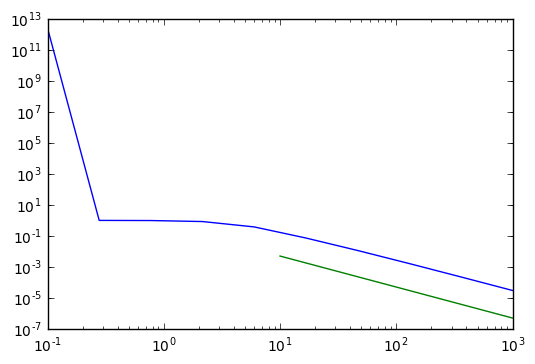

In [21]:
plt.loglog(KV, s4.real)
plotlog(1e1, 5e-3, -2, xrange=2)
plt.show()

In [12]:
import cProfile
cProfile.run('s4wlc(pset, N, FA, Ks, sequence=sequence)')

         4384789 function calls (4383989 primitive calls) in 63.239 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    19200    0.028    0.000    0.038    0.000 <frozen importlib._bootstrap>:996(_handle_fromlist)
        4    0.000    0.000    0.000    0.000 <ipython-input-3-f4b7cbf9e8bd>:2(__init__)
        1    0.000    0.000    0.000    0.000 <ipython-input-5-4c9741b7fa37>:1(norm)
     2400    0.085    0.000   63.215    0.026 <ipython-input-7-82487a00d993>:1(I4N)
        1    0.019    0.019   63.239   63.239 <ipython-input-8-a06ba42c7f13>:6(fourPointCorr)
        1    0.000    0.000   63.239   63.239 <ipython-input-9-3088a0d0d0b8>:1(s4wlc)
        1    0.000    0.000   63.239   63.239 <string>:1(<module>)
     9600    0.008    0.000    0.017    0.000 <string>:12(__new__)
3200/2400   46.762    0.015   62.802    0.026 MultiPoint.py:290(IAAAAresum)
     1600    0.876    0.001    1.251    0.001 MultiPoint.py:331(IAAAAresumK

In [13]:
N=1.0
FA=0.2

nlam=10
pset=propagator.prop_set(nlam=nlam)

def set4Ks(K):
    k1=np.array([0,0,1])*K
    k2=np.array([0,0,1])*K
    k3=-k1
    k4=-k2

    k = [k1, k2, k3, k4]
    return k

K = 10.0
k = set4Ks(K)

print(s4wlc(pset, N, FA, k, sequence=[0, 0, 0, 0]))
print(s4wlc(pset, N, FA, k, sequence=[0, 0, 0, 1]))
print(s4wlc(pset, N, FA, k, sequence=[0, 0, 1, 0]))
print(s4wlc(pset, N, FA, k, sequence=[0, 1, 0, 0]))
print(s4wlc(pset, N, FA, k, sequence=[1, 0, 0, 0]))

print(s4wlc(pset, N, FA, k, sequence=[1, 1, 0, 0]))
print(s4wlc(pset, N, FA, k, sequence=[0, 0, 1, 1]))

print(s4wlc(pset, N, FA, k, sequence=[1, 0, 0, 1]))
print(s4wlc(pset, N, FA, k, sequence=[0, 1, 1, 0]))

print(s4wlc(pset, N, FA, k, sequence=[1, 0, 1, 0]))
print(s4wlc(pset, N, FA, k, sequence=[0, 1, 0, 1]))

/home/users/qmac/MultiPointCalculation/WLCgreen.py:1311: RuntimeWarning: invalid value encountered in multiply
  dinvG=np.ones((nlam,nlam),dtype='complex')*np.inf


(0.00128181639932-7.8435146457e-17j)
(0.000317731103746+1.40920003367e-17j)
(0.000317731103746+1.40920003367e-17j)
(0.000317731103746+1.40920003367e-17j)
(0.000317731103746+1.40920003367e-17j)
(-9.2626826525e-05+2.52344698539e-19j)
(-9.2626826525e-05+2.52344698539e-19j)
(0.00749545407137+1.89914544414e-18j)
(0.00749545407137+1.89914544414e-18j)
(0.00749545407137+1.89914544414e-18j)
(0.00749545407137+1.89914544414e-18j)


In [ ]:
# KV = np.logspace(-1,3,10)
# s4 = np.zeros((2,2,2,2,len(KV)),dtype=type(1+1j))
# for ind, K in enumerate(KV):
#     Ks = setKs(K)
#     s4[:,:,:,:,ind] = s4wlc(pset, N, FA, Ks)/(N**4)

In [ ]:
# plt.loglog(KV, s4[0,0,0,0,:])
# plotlog(1e1, 5e-3, -2, xrange=2)
# plt.show()

## Rigid rod limit structure FActor

Consider the special case that the four wavevectors form a straight line.

The structure FActor of a rigid rod after rotation average is
\begin{eqnarray}
I_4 = 
\int_{0}^{L} ds_1
\int_{0}^{L} ds_2
\int_{0}^{L} ds_3
\int_{0}^{L} ds_4
\frac{\sin{kL(s_1 + s_2 - s_3 - s_4)}}
{kL(s_1 + s_2 - s_3 - s_4)}
\end{eqnarray}